In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os

from net.network import AttentionNet, SelfAttention, vgg_reverse, vgg

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--image', type=str, default='./datasets/test/content/lenna.jpg',
                    help='Directory path to a batch of content images')
parser.add_argument('--vgg_model', type=str, default='./models/vgg/vgg_normalised.pth')
parser.add_argument('--attn_model', type=str, default='models/attention_training/',
                    help='Directory path to a batch of style images')
parser.add_argument('--decoder_model', type=str, default='models/adain_mult_attn/',
                    help='Directory path to a batch of style images')
args = parser.parse_args('')

image_name = args.image.split('/')[-1].split('.')[0]
attn_model_dir = args.attn_model.split('/')[-2]
decoder_model_dir = args.decoder_model.split('/')[-2]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

shape: torch.Size([3, 400, 400])


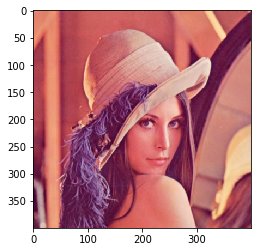

In [4]:
# load test data
def test_transform(size = 512):
    transform = transforms.Compose([
        transforms.Resize(size=(size, size)),
        # transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ])
    return transform

def test_transform_inv():
    transform = transforms.Compose([
        transforms.Normalize((0, 0, 0), (2, 2, 2)),
        transforms.Normalize((-_R_MEAN/255.0, -_G_MEAN/255.0, -_B_MEAN/255.0), (1, 1, 1))
    ])
    return transform

content_tf = test_transform(400)
content_tf_inv = test_transform_inv()
content = content_tf(Image.open(args.image).convert('RGB'))
print("shape: " + str(content.shape))

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(content_tf_inv(content)))

In [5]:
def get_optimizer(model, seperate):
    for param in model.encode.parameters():
        param.requires_grad = False
    if seperate == True:
        optimizer = torch.optim.Adam([
            {'params': model.self_attn_content.parameters()},
            {'params': model.self_attn_style.parameters()},
            {'params': model.content_decode.parameters()},
            {'params': model.style_decode.parameters()},
        ], lr=args.lr)
    else:
        optimizer = torch.optim.Adam([
            {'params': model.decode.parameters()},
            {'params': model.self_attn.parameters()},
        ], lr=args.lr)
    return optimizer

def state_to_device(parameter, device):
    state_dict = parameter.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    parameter.cuda()
        
encoder = vgg
encoder.load_state_dict(torch.load(args.vgg_model))
state_to_device(encoder, device)
decoder = vgg_reverse
decoder.load_state_dict(torch.load(args.decoder_model + 'decoder_iter_80000.pth'))
state_to_device(decoder, device)
attn = SelfAttention()
attn.load_state_dict(torch.load(args.attn_model + 'attention_kernel_iter_80000.pth'))
state_to_device(attn, device)

# if(args.start_iter > 0):
#     decoder = vgg_reverse
#     decoder.load_state_dict(torch.load(args.save_dir + '/decoder_iter_' + str(args.start_iter) + '.pth'))
#     state_to_device(decoder, device)
    
#     attn = SelfAttention()
#     attn.load_state_dict(torch.load(args.save_dir + '/attention_kernel_iter_' + str(args.start_iter) + '.pth'))
#     state_to_device(attn, device)
    
#     model = AttentionNet(attn=attn, encoder = encoder, decoder = decoder)
#     optimizer = get_optimizer(model, args.seperate)
#     optimizer.load_state_dict(torch.load(args.save_dir + '/optimizer_iter_' + str(args.start_iter) + '.pth'))
#     for state in optimizer.state.values():
#         for k, v in state.items():
#             if isinstance(v, torch.Tensor):
#                 state[k] = v.cuda()
# else:

model = AttentionNet(attn=attn, encoder=encoder, decoder=decoder)
loss_seq = {'total': [], 'construct': [], 'percept': [], 'tv': [], 'attn': []}
model.to(device)   


AttentionNet(
  (encode): Encoder()
  (self_attn): SelfAttention(
    (corr): Correlation(
      (f): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (g): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (h): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  )
  (decode): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): ReflectionPad2d((1, 1, 1, 1))
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): ReflectionPad2d((1, 1, 1, 1))
    (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): Upsample(

In [6]:
content = torch.stack([content], dim = 0)
content = content.to(device)

In [7]:
projection_method_test = 'AdaIN'
loss_dict, output, attention_feature_map, attention_map = model.test(content, projection_method_test)

torch.Size([1, 512, 50, 50])


In [8]:
def imshow_recon(img, save_dir):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if save_dir != None:
        torchvision.utils.save_image(img, save_dir)

def show_output(output, save_dir=None):
    print("Saving to " + str(save_dir))
    content_result = content_tf_inv(output.squeeze())
    imshow_recon(torchvision.utils.make_grid(content_result.cpu()), save_dir)

def save_attn_map(attn_map, save_dir=None):
    channel_num = attn_map.size()[1]
    mean_sal = torch.mean(attn_map, 1, False)
    mean_sal = mean_sal / torch.sum(mean_sal)
    print(torch.min(mean_sal[0]))
    print(torch.max(mean_sal[0]))
    print(torch.sum(mean_sal[0]))
    mean_sal_np = mean_sal.cpu().detach().numpy()
#     mean_sal_np = mean_sal_np - np.min(mean_sal_np)
#     mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
    plt.imshow(mean_sal_np[0], cmap=cm.get_cmap('rainbow', 1000))
    plt.colorbar()
    plt.axis('off')
    if save_dir != None:
        plt.savefig(save_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving to None


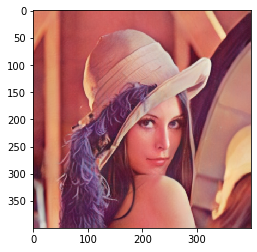

In [9]:
show_output(output)

tensor(1.0481e-07, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0038, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)


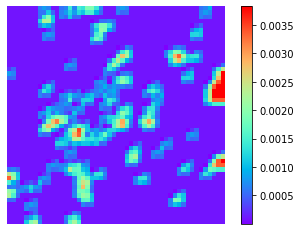

In [10]:
save_attn_map(attention_map)